In [2]:
%%capture --no-stderr
!pip install langchain langgraph langchain_openai langchain_experimental langchain_core langsmith pandas matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import getpass
import os

def set_if_undefined(var:str):
    if var not in os.environ:  # Check if the specific variable is undefined
        os.environ[var] = getpass.getpass(f"Please enter the {var} key: ")

set_if_undefined("OPENAI_API_KEY")
set_if_undefined("TAVILY_API_KEY")

In [ ]:
import os
from langsmith import Client

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = ""
os.environ["LANGCHAIN_PROJECT"] = "Multi Agent Collaboration"

client = Client()


### Creating Agents

In [30]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

### Define Tools

In [31]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

### Create Graph

#### Define State

In [32]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI


# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

### Define agent nodes

In [33]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }


llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
research_agent = create_agent(
    llm,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    llm,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

### Tool Node

In [34]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

### Define Edge Logic
This logic helps us decide what to do based on results of the agents

In [35]:
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return "continue"

### Define the Graph

In [38]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "chart_generator",
    router,
    {"continue":"Researcher", "call_tool":"call_tool",END:END}
)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue":"chart_generatory", "call_tool":"call_tool",END:END}
)

workflow.add_conditional_edges(
    "call_tool",
    #Each agent will update the sender field but the call_tool node will not
    #It will return back to the agent that invoked it
    lambda x: x["sender"],
    {"Researcher":"Researcher", "chart_generator":"chart_generator"} 
)

workflow.add_edge(START, "Researcher")
graph = workflow.compile()

ValueError: At 'Researcher' node, 'router' branch found unknown target 'chart_generatory'

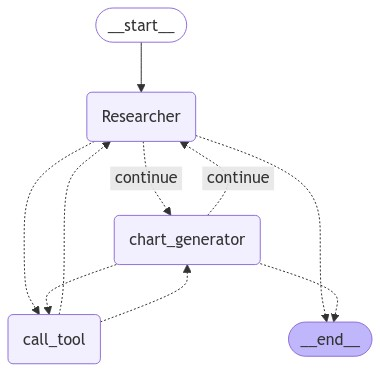

In [39]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph(xray = True).draw_mermaid_png()))
except Exception:
    pass


### Invoke

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GeQABSTNLkuhUGmVRNltMVVn', 'function': {'arguments': '{"query":"UK GDP past 5 years"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 217, 'total_tokens': 240, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='run-0f946a1f-25df-4166-bcec-a22c3b4dc416-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': 'call_GeQABSTNLkuhUGmVRNltMVVn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 217, 'output_tokens': 23, 'total_tokens': 240, 

Python REPL can execute arbitrary code. Use with caution.


{'chart_generator': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wUUjLs3R1flGVyVAyES7iG5Q', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Data for the UK\'s GDP over the past 5 years\\nyears = [2018, 2019, 2020, 2021, 2022]\\ngdp_values = [3087.35, 2851.71, 2697.81, 3141.51, 3088.84]\\n\\n# Create a line graph\\nplt.figure(figsize=(10, 6))\\nplt.plot(years, gdp_values, marker=\'o\')\\nplt.title(\\"UK\'s GDP Over the Past 5 Years\\")\\nplt.xlabel(\\"Year\\")\\nplt.ylabel(\\"GDP in Billion USD\\")\\nplt.grid(True)\\nplt.xticks(years)\\nplt.show()"}', 'name': 'python_repl'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 171, 'prompt_tokens': 2562, 'total_tokens': 2733, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'm

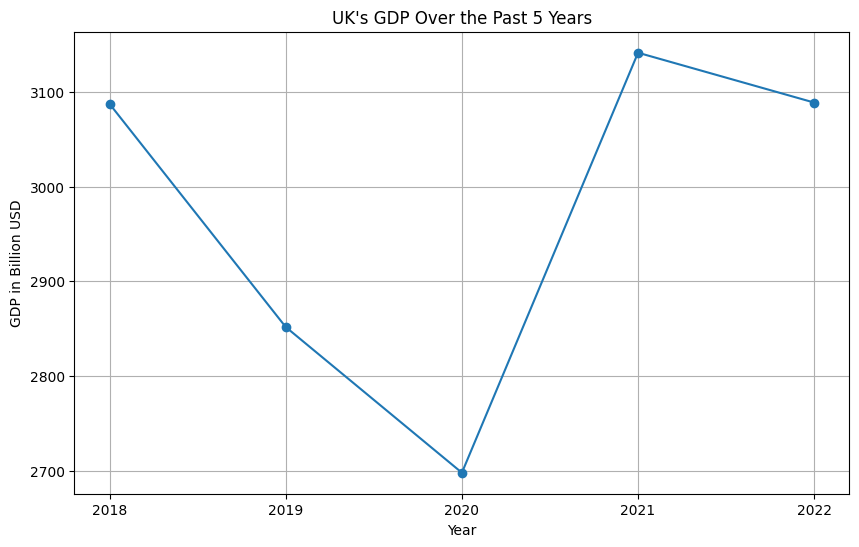

{'call_tool': {'messages': [ToolMessage(content='Successfully executed:\n```python\nimport matplotlib.pyplot as plt\n\n# Data for the UK\'s GDP over the past 5 years\nyears = [2018, 2019, 2020, 2021, 2022]\ngdp_values = [3087.35, 2851.71, 2697.81, 3141.51, 3088.84]\n\n# Create a line graph\nplt.figure(figsize=(10, 6))\nplt.plot(years, gdp_values, marker=\'o\')\nplt.title("UK\'s GDP Over the Past 5 Years")\nplt.xlabel("Year")\nplt.ylabel("GDP in Billion USD")\nplt.grid(True)\nplt.xticks(years)\nplt.show()\n```\nStdout: \n\nIf you have completed all tasks, respond with FINAL ANSWER.', name='python_repl', tool_call_id='call_wUUjLs3R1flGVyVAyES7iG5Q')]}}
----
{'chart_generator': {'messages': [AIMessage(content="FINAL ANSWER\nHere is the line graph showing the UK's GDP over the past 5 years:\n\n![UK's GDP Over the Past 5 Years](attachment://chart.png)", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 2913, 'total_tokens': 295

In [40]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Fetch the UK's GDP over the past 5 years,"
                " then draw a line graph of it."
                " Once you code it up, finish."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")